In [1]:
from torch import nn
from torch.utils.data import DataLoader, Dataset
import pandas as pd
import torch
import numpy as np
import matplotlib.pyplot as plt



In [ ]:
def number_to_feature_vector(n, n_min=0, n_max=1000):
    """
    Convert a number to a 42-feature vector:
    - 10 least significant digits from binary, ternary, quinary, septenary representations
    - Normalized number
    - Normalized logarithm of the number
    
    Parameters:
    n (int/float): Input number (positive)
    n_min (float): Minimum value for normalization (default: 0)
    n_max (float): Maximum value for normalization (default: 1000)
    
    Returns:
    np.array: 42-dimensional feature vector
    """
    feature_vector = []
    
    def to_base_digits(num, base, k=10):
        if num == 0:
            return [0] * k
        digits = []
        while num > 0 and len(digits) < k:
            digits.append(num % base)
            num //= base
        while len(digits) < k:
            digits.append(0)
        return digits[::-1][:k]
    
    bases = [2, 3, 5, 7]  
    for base in bases:
        digits = to_base_digits(int(n), base, 10)
        feature_vector.extend(digits)
    
    # Normalize the number (min-max scaling)
    n_norm = (n - n_min) / (n_max - n_min) if n_max != n_min else 0.0
    feature_vector.append(n_norm)
    
    log_n = np.log(n) if n > 0 else 0.0
    log_min = np.log(n_min) if n_min > 0 else -10
    log_max = np.log(n_max) if n_max > 0 else 10  
    log_norm = (log_n - log_min) / (log_max - log_min) if log_max != log_min else 0.0
    feature_vector.append(log_norm)
    
    return np.array(feature_vector)



In [ ]:
class Neural_nets(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Sequential(
                nn.Linear(42, 200),        
                nn.ReLU(),
                nn.Linear(200, 200),       
                nn.BatchNorm1d(200),        
                nn.ReLU(),
                nn.Linear(200, 100),        
                nn.BatchNorm1d(100),        
                nn.ReLU(),
                nn.Linear(100, 100),        
                nn.BatchNorm1d(100),        
                nn.ReLU(),
                nn.Linear(100, 10),        
                nn.ReLU(),
                nn.Linear(10, 1),          
    
            )
        
    def forward(self,x):
        logits = self.linear(x)
        return logits

In [55]:
class golbach_datasets(Dataset):
    def __init__(self,file_name):
        self.df = pd.read_csv(file_name)
        self.number = self.df["Even_number"]
        self.combination = self.df["combination"]
        self.numbers = []
        for i in self.number:
            self.numbers.append(number_to_feature_vector(i))
        self.numbers = np.array(self.numbers)        

    def __len__(self):
        return len(self.number)
    
    def __getitem__(self, index):
        return {"number":self.numbers[index],"combination":self.combination[index]}
        

In [56]:
data = golbach_datasets("data.csv")

In [57]:
function = Neural_nets()

In [58]:
data_loader = DataLoader(data, batch_size=2,shuffle=True,drop_last=True)


In [59]:
loss_fn = torch.nn.MSELoss()

optimizer = torch.optim.SGD(function.parameters(), lr=0.01)


In [ ]:
def train_epoch():
    running_loss = 0.


    for i, data in enumerate(data_loader):
        inputs, labels = data["number"].to(dtype =torch.float32) , data["combination"].to(dtype = torch.float32)

        optimizer.zero_grad()

        inputs = inputs.squeeze()
        outputs = function(inputs)

        loss = loss_fn(outputs.squeeze(), labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(function.parameters(), max_norm=1.0)
        optimizer.step()
        running_loss += loss.item()


    return running_loss/len(data_loader)

In [61]:
epochs = 15

for epoch in range(epochs):

    function.train(True)
    avg_loss = train_epoch()
    print(f"Epoch:{epoch+1} loss:{avg_loss}")

Epoch:1 loss:2225169.023873595
Epoch:2 loss:2158749.5200050836
Epoch:3 loss:2153594.510845432
Epoch:4 loss:2152633.2073040046
Epoch:5 loss:2153341.657513748
Epoch:6 loss:2151673.6626792
Epoch:7 loss:2150604.7624519696
Epoch:8 loss:2147955.2101472896
Epoch:9 loss:2149377.820380891
Epoch:10 loss:2155160.2453158763
Epoch:11 loss:2153418.136795368
Epoch:12 loss:2154209.867392667
Epoch:13 loss:2151753.9136331696
Epoch:14 loss:2152201.6064447677
Epoch:15 loss:2153472.4123671455


In [62]:
function.eval()
vec = number_to_feature_vector(100)
vec = torch.tensor(vec, dtype=torch.float32)
vec = vec.unsqueeze(0)
with torch.no_grad():
    out = function(vec) 
    print(out)

tensor([[1879.9113]])


In [39]:
torch.save(function.state_dict(), "Function.pth")

In [63]:
df = pd.read_csv("data.csv")
df.head()
print(len(df))

336645


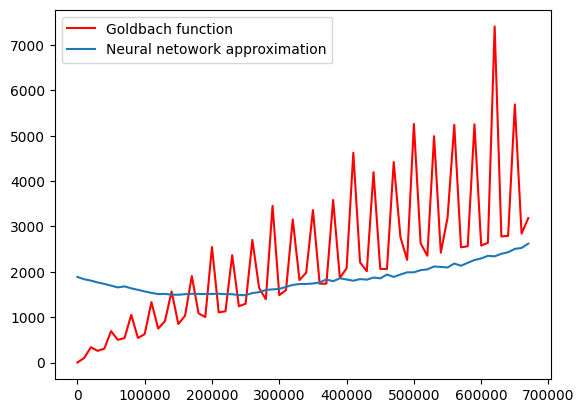

In [73]:
even_number = df["Even_number"][::5000]

combination = df["combination"][::5000]
tensors =[]
function.eval()
out_lis = []

for i in even_number:
    tensors.append(torch.tensor(number_to_feature_vector(i),dtype=torch.float32))
with torch.no_grad():
    for j in tensors:
        
        out  = function(j.unsqueeze(0))
        out_lis.append(out.item())
plt.plot(even_number, combination, color="red",label ="Goldbach function")
plt.plot(even_number,out_lis,label = "Neural netowork approximation")
plt.legend()
plt.show()

In [72]:
from sklearn.metrics import r2_score
score = r2_score(combination, np.array(out_lis))
print("The accuracy of our model is {}%".format(round(score, 2) *100))


The accuracy of our model is 13.0%
